In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from sklearn import linear_model
from random import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

In [57]:
df_music = pd.read_csv('../music_data/dataset-11-30.csv')

In [58]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,79,5.591987,Keith,98.6,1967,390830,414
1,96,4.917009,Eddie Hodges,"(Girls, Girls, Girls) Made To Love",1962,30625,688
2,3,48.428383,The Rolling Stones,(I Can't Get No) Satisfaction,1965,120360439,13638
3,43,8.354314,"Clarence ""Frogman"" Henry",(I Don't Know Why) But I Do,1961,1646381,553
4,64,6.425711,The Reflections,(Just Like) Romeo and Juliet,1964,182525,623


# 0 Utility

In [59]:
def z_score_norm(df, feature_list):
    """ Do the z-score method on selected features in feature_list. 
        z = (x - mean)/std

    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())
        
        
        
def do_log(df, feature_list):
    '''Do logarithm on selected features in feature_list.
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    '''
    
    for col in feature_list:
        df[col] = np.log(df[col])
        
        
        
def powerlaw_rank(df_music):
    ''' Do powerlaw on the original rank.
        y = 100*rank^(-0.66)
        However, I find that differnent coefficient and exponent do not affect MAE. Don't know why.
    
    Args:
        df_music (pandas.DataFrame): dataset
    '''
    
    df_music.insert(1, 'RankPowerlaw', df_music.Rank)  # insert right next to column 'Rank'
    df_music['RankPowerlaw'] = df_music['RankPowerlaw'].astype('float')
    for i in range(0, len(df_music)):
        df_music.iat[i,1] = 100 * math.pow(df_music.iat[i,1], -0.66)

In [60]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
    
    
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    fig = plt.figure()
    ax = err.plot.hist(bins=20, figsize=(7,7), edgecolor='black')
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()
    
    fig.savefig('../figure/%s_error_dist.png' % model_name)
    
    

def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    #plt.scatter(target, pred, edgecolor='black', s=15)
    plt.scatter(target, pred, s=13)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    #ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()
    
    fig.savefig('../figure/%s_error_map.png' % model_name)
    
    
    
def permutation_test(model,target,pred):
    '''do permuation tests
    
    Args:
        model_name: model
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae  = mean_absolute_error(target,pred)
    mae_list=[mae]
    count=0
    while count<100:
        count = count+1 
        target_to_list = target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle = mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins)
    ax.set_title('Permutation test')
    ax.set_xlabel('$Log(playcount)-mae$', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.get_children()[0].set_color('r')
    ax.grid()
    
    
    
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    #permutation_test(model, target, pred)
    
    performance_statistics(model_name, target, pred)    

# 1 Baseline

In [61]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,79,5.591987,Keith,98.6,1967,390830,414
1,96,4.917009,Eddie Hodges,"(Girls, Girls, Girls) Made To Love",1962,30625,688
2,3,48.428383,The Rolling Stones,(I Can't Get No) Satisfaction,1965,120360439,13638
3,43,8.354314,"Clarence ""Frogman"" Henry",(I Don't Know Why) But I Do,1961,1646381,553
4,64,6.425711,The Reflections,(Just Like) Romeo and Juliet,1964,182525,623


In [62]:
do_log(df_music, feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount'])

In [63]:
z_score_norm(df_music, feature_list=['Rank', 'RankPowerlaw', 'Year', 'WikiWordCount'])

In [64]:
feature = df_music.loc[:,['Rank', 'Year', 'WikiWordCount']]
target  = df_music.loc[:,['SpotifyPlayCount']]

In [65]:
lr = linear_model.LinearRegression()

In [66]:
reg = linear_model.Ridge (alpha = .8)

This is the plots/reports of LinearRegression


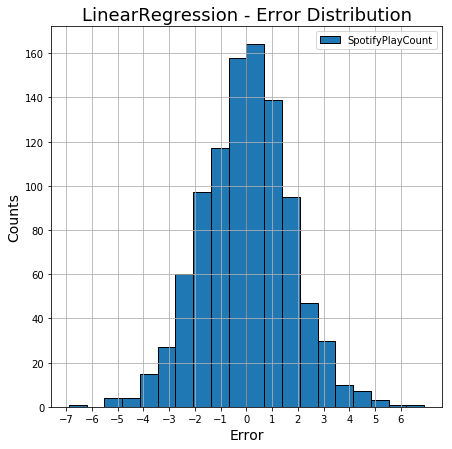

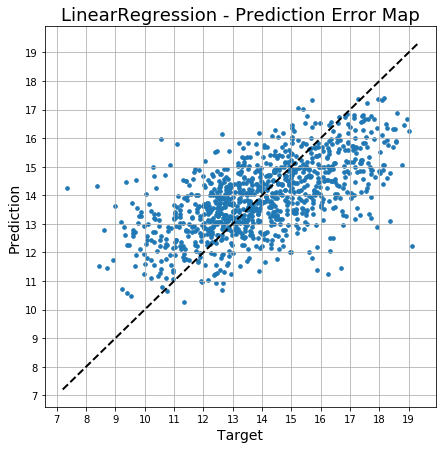

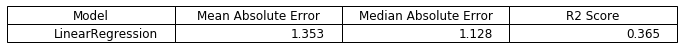

In [67]:
evaluation(lr, feature, target)

In [68]:
pred = cross_val_predict(lr, X=feature, y=target, cv=10)  # default is 10-fold

# Twenty Best

In [69]:
def top20BetterThanPrediction(pred, target):
    array = target - pred

In [70]:
best = target - pred

In [71]:
best.insert(0, 'Prediction', pred)

In [72]:
best.insert(0, 'Target', target)

In [73]:
best.describe()

,Target,Prediction,SpotifyPlayCount
count,980.000000,980.000000,980.000000
mean,13.910214,13.909984,0.000230
std,2.162192,1.315905,1.723084
min,7.348588,10.248472,-6.901738
25%,12.445243,13.014725,-1.132129
50%,13.791597,13.864857,-0.046243
75%,15.460983,14.814092,1.122740
max,19.119101,17.388301,6.891002


In [74]:
best_index = best.nlargest(20, columns='SpotifyPlayCount').index

In [75]:
best.nlargest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
37,19.119101,12.228099,6.891002
938,18.355697,13.101444,5.254253
724,16.674597,11.466242,5.208355
723,17.907229,12.876138,5.031092
469,16.255563,11.232013,5.023550
758,17.717049,13.189622,4.527427
533,15.887576,11.391955,4.495620
919,17.636537,13.341282,4.295255
581,16.316187,12.040122,4.276065
660,17.322973,13.308602,4.014371


In [76]:
df_music.iloc[best_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
37,1.262602,-0.899769,Marvin Gaye and Tammi Terrell,Ain't No Mountain High Enough,0.856207,19.119101,-1.172056
938,1.021195,-0.809141,Sam Cooke,Wonderful World,-1.566886,18.355697,0.367648
724,1.641956,-1.028403,Maurice Williams and the Zodiacs,Stay,-1.566886,16.674597,-0.877456
723,0.434920,-0.551037,Ben E. King,Stand By Me,-1.220730,17.907229,-0.295236
469,0.021079,-0.322733,Billy Bland,Let The Little Girl Dance,-1.566886,16.255563,-1.924675
758,1.538496,-0.994812,Dave Brubeck,Take Five,-1.220730,17.717049,0.584029
533,1.607469,-1.017322,Barrett Strong,Money,-1.566886,15.887576,-0.917099
919,1.055681,-0.822563,Cream,White Room,1.202363,17.636537,-0.369444
581,1.641956,-1.028403,The Chiffons,One Fine Day,-0.528418,16.316187,-0.658198
660,-0.082381,-0.257233,Scott Mckenzie,San Francisco (Be Sure to Wear Flowers in Your...,0.856207,17.322973,-0.932398


In [77]:
lr2 = linear_model.LinearRegression()

In [78]:
lr2.fit(feature, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [79]:
feature.head()

,Rank,Year,WikiWordCount
0,0.986708,0.856207,-1.496953
1,1.572982,-0.874574,-1.009994
2,-1.634284,0.163894,1.853552
3,-0.254815,-1.220730,-1.219410
4,0.469407,-0.182262,-1.105141


In [80]:
lr2.coef_

array([[-0.57695947,  0.38305191,  1.04738194]])

# Twenty Worst

In [81]:
best.nsmallest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
76,7.348588,14.250325,-6.901738
466,8.377471,14.337984,-5.960513
652,10.539509,15.972473,-5.432964
505,9.375601,14.478531,-5.102931
485,9.691964,14.538380,-4.846416
490,10.271043,14.972546,-4.701503
102,11.114401,15.800872,-4.686471
101,8.977146,13.638957,-4.661811
972,10.325416,14.687086,-4.361669
520,10.852826,15.053638,-4.200811


In [82]:
worst_index = best.nsmallest(20, columns='SpotifyPlayCount').index

In [83]:
df_music.iloc[worst_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
76,-0.772116,0.325112,Andy Kim,"Baby, I Love You",1.548519,7.348588,-0.647636
466,1.710929,-1.050231,Paul Revere and The Raiders,Let Me,1.548519,8.377471,0.717286
652,0.228000,-0.442904,The Temptations,"Run Away Child, Running Wild",1.548519,10.539509,1.508823
505,-1.082497,0.744063,The Ray Charles Singers,Love Me with All Your Heart (Cuando Calienta E...,-0.182262,9.375601,-0.039134
485,1.435036,-0.960143,Bill Cosby,Little Ole Man (Uptight-Everything's Alright),0.856207,9.691964,1.028370
490,-0.323788,-0.086927,Bobby Sherman,Little Woman,1.548519,10.271043,0.240337
102,-1.323904,1.240553,Roger Williams,Born Free,0.510051,11.114401,0.914471
101,-0.461735,0.023983,Sandy Posey,Born a Woman,0.510051,8.977146,-0.714873
972,-0.944550,0.537642,Bobby Darin,You're The Reason I'm Living,-0.528418,10.325416,0.411660
520,0.262486,-0.461695,Lonnie Mack,"Memphis, Tennessee",-0.528418,10.852826,1.368742


## Spotipy

In [84]:
import spotipy

In [85]:
spotify = spotipy.Spotify()